In [1]:
import torch
import numpy as np
import pandas as pd

/home/james/.pyenv/versions/3.7.16/envs/kaggle3.7/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import seaborn.objects as so

In [3]:
df_0 = pd.read_csv("data.csv", index_col=0)

# split into train and test
test_size = 4000
df_train = df_0.iloc[:-2*test_size]
df_dev = df_0.iloc[-2*test_size:-test_size]
df_test = df_0.iloc[-test_size:]
df_train.head()

,author,geometry,pressure [MPa],mass_flux [kg/m2-s],x_e_out [-],D_e [mm],D_h [mm],length [mm],chf_exp [MW/m2]
id,,,,,,,,,
0,Thompson,tube,7.00,3770.0,0.1754,NaN,10.8,432.0,3.6
1,Thompson,tube,NaN,6049.0,-0.0416,10.3,10.3,762.0,6.2
2,Thompson,NaN,13.79,2034.0,0.0335,7.7,7.7,457.0,2.5
3,Beus,annulus,13.79,3679.0,-0.0279,5.6,15.2,2134.0,3.0
4,NaN,tube,13.79,686.0,NaN,11.1,11.1,457.0,2.8


In [4]:
# mask of missing data
# mask = df_0.isnull()
# mask.head()
df_train.describe()

,pressure [MPa],mass_flux [kg/m2-s],x_e_out [-],D_e [mm],D_h [mm],length [mm],chf_exp [MW/m2]
count,20330.000000,20070.000000,15845.000000,19574.000000,20265.000000,20123.000000,23644.000000
mean,10.628599,3060.824564,0.000006,8.621105,14.142832,829.462605,3.791740
std,4.334998,1778.014723,0.100673,5.161892,19.849561,671.040953,1.970519
min,0.100000,0.000000,-0.866700,1.000000,1.000000,10.000000,0.800000
25%,6.890000,1505.000000,-0.046500,4.775000,5.600000,318.000000,2.400000
50%,11.030000,2730.000000,0.004900,7.800000,10.000000,610.000000,3.400000
75%,13.790000,4069.000000,0.064900,10.800000,11.500000,914.000000,4.600000
max,20.680000,7975.000000,0.232000,37.500000,120.000000,3048.000000,19.300000


In [5]:
df_train["mass_flux [kg/m2-s]"].value_counts()

4069.0    712
1356.0    485
1519.0    474
2034.0    387
1000.0    314
         ... 
3567.0      1
5871.0      1
791.0       1
881.0       1
849.0       1
Name: mass_flux [kg/m2-s], Length: 701, dtype: int64

In [6]:
df1 = pd.get_dummies(df_train["geometry"]).head().copy()
df1[df_train["geometry"].head().isnull()] = np.nan
df1

,annulus,plate,tube
id,,,
0,0.0,0.0,1.0
1,0.0,0.0,1.0
2,NaN,NaN,NaN
3,1.0,0.0,0.0
4,0.0,0.0,1.0


<AxesSubplot:xlabel='pressure [MPa]', ylabel='Count'>

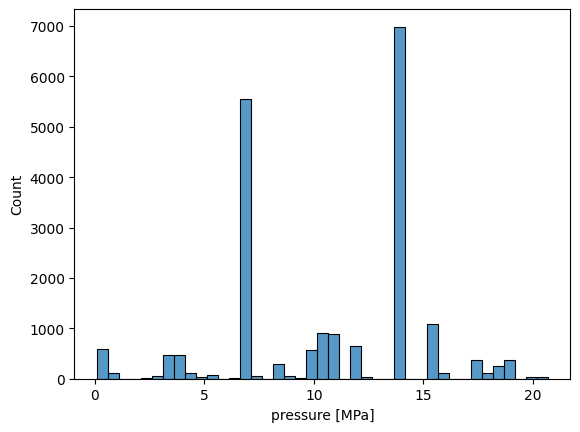

In [7]:
# use seaborn to plot the histograms for each column individually and stack them
# sns.histplot(df_train, x="geometry", hue="geometry", multiple="stack")
# sns.histplot(df_train, x="author", hue="author", multiple="stack")
sns.histplot(df_train, x="pressure [MPa]", multiple="stack")



In [8]:
from torch.utils.data import Dataset, DataLoader

In [9]:
class MaskingDataset(Dataset):
    def __init__(self, df, p_mask=0.2, categorical_cols=None):
        self.features = len(df.columns)
        self.p_mask = p_mask

        self._categorical_cols = []
        if categorical_cols is not None:
            for col in categorical_cols:
                one_hot = pd.get_dummies(df[col])
                one_hot[df[col].isnull()] = np.nan

                self._categorical_cols.append(one_hot.columns)
                df = df.drop(col, axis=1)
                df = pd.concat([df, one_hot], axis=1)

        self.df = df

    def __len__(self):
        return len(self.df)

    def onehot_categorical_mask(self, column_mask):
        return np.concatenate(
            [np.full(len(cs), m) for m, cs in zip(column_mask, self._categorical_cols)]
        )

    def __getitem__(self, idx):
        record = self.df.iloc[idx]
        output_mask = torch.tensor(~record.isnull().values)

        input_mask = ~np.random.binomial(1, self.p_mask, size=self.features).astype(
            bool
        )

        # mask continuous columns normally
        # mask categorical columns with all their columns

        full_input_mask = (
            torch.tensor(
                np.concatenate(
                    [
                        input_mask[: -len(self._categorical_cols)],
                        self.onehot_categorical_mask(
                            input_mask[-len(self._categorical_cols) :]
                        ),
                    ]
                )
            )
            & output_mask
        )

        x_in = record.values.copy()
        x_in[~full_input_mask] = 0

        x_out = record.values.copy()
        x_out[~output_mask] = np.nan

        # x = torch.tensor(record.values)
        # return masked_tensor(x, full_input_mask), masked_tensor(x, output_mask)
        return (
            torch.as_tensor(x_in, dtype=torch.float32),
            torch.as_tensor(x_out, dtype=torch.float32),
        )

In [22]:
import torch.nn as nn


class FFModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()

        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, output_size)

        self.activation = nn.ReLU()
        # self.activation = nn.Sigmoid()

    def forward(self, x0):
        x = self.activation(self.fc1(x0))
        x = self.activation(self.fc2(x))

        return self.fc3(x)


def separate_slices(categorical_slices, output_size):
    slices = []
    slice_is_categorical = []
    prev_start = 0
    for start, end in categorical_slices:
        if start != prev_start:
            slices.append(slice(prev_start, start))
            slice_is_categorical.append(False)
        slices.append(slice(start, end))
        slice_is_categorical.append(True)
        prev_start = end

    if prev_start != output_size:
        slices.append(slice(prev_start, output_size))
        slice_is_categorical.append(False)

    return slices, slice_is_categorical


class MixedContCatModel(nn.Module):
    def __init__(self, model, categorical_slices, output_size) -> None:
        super().__init__()

        self.model = model
        
        self.softmax = nn.Softmax(dim=1)

        self.slices, self.slice_is_categorical = separate_slices(
            categorical_slices, output_size
        )

    def forward(self, x):
        x = self.model(x)
        for slice_, is_categorical in zip(self.slices, self.slice_is_categorical):
            if is_categorical:
                x[:, slice_] = self.softmax(x[:, slice_])
        return x

In [11]:
class ContCatLoss(nn.Module):
    def __init__(
        self,
        categorical_slices,
        output_size,
        cont_loss=nn.MSELoss(),
        cat_loss=nn.CrossEntropyLoss(),
    ) -> None:
        super().__init__()

        self.n_cats = len(categorical_slices)
        slices, slice_is_categorical = separate_slices(categorical_slices, output_size)
        self.cont_slices = [s for s, is_cat in zip(slices, slice_is_categorical) if not is_cat]
        self.cat_slices = [s for s, is_cat in zip(slices, slice_is_categorical) if is_cat]

        self.cont_loss = cont_loss
        self.cat_loss = cat_loss


    def forward(self, y_pred, y_true):
        output_mask = ~torch.isnan(y_true)
        y_pred = y_pred * output_mask
        y_true = y_true.where(output_mask, torch.tensor(0.0))

        y_pred_cont = torch.concat([y_pred[:, s] for s in self.cont_slices], dim=1)
        y_true_cont = torch.concat([y_true[:, s] for s in self.cont_slices], dim=1)
        loss_cont = self.cont_loss(y_pred_cont, y_true_cont)

        losses_cat = []
        for s in self.cat_slices:
            y_pred_cat = y_pred[:, s]
            y_true_cat = y_true[:, s]
            losses_cat.append(self.cat_loss(y_pred_cat, y_true_cat))
        
        
        return loss_cont, losses_cat

class MixedContCatLoss(nn.Module):
    def __init__(self, contcatloss, ratio):
        super().__init__()

        self.contcatloss = contcatloss
        self.ratio = ratio
    
    def forward(self, y_pred, y_true):
        loss_cont, losses_cat = self.contcatloss(y_pred, y_true)

        loss_cat = sum(losses_cat)

        return self.ratio * loss_cont + (1 - self.ratio) * loss_cat

In [12]:
# transform df_train by taking log of positive columns and normalizing
df_train_log = df_train.select_dtypes(include=[float]).copy().drop(columns=["x_e_out [-]"])
df_train_log[df_train_log == 0] += 1e-6
df_train_log = np.log(df_train_log)

# add back x_e_out
df_train_log["x_e_out [-]"] = df_train["x_e_out [-]"]

means = df_train_log.mean()
stds = df_train_log.std()
df_train_log = (df_train_log - means) / stds

df_train_log = pd.concat([df_train_log, df_train.select_dtypes(include=[object])], axis=1)
df_train_log.head()

,pressure [MPa],mass_flux [kg/m2-s],D_e [mm],D_h [mm],length [mm],chf_exp [MW/m2],x_e_out [-],author,geometry
id,,,,,,,,,
0,-0.287262,0.526524,NaN,0.200611,-0.226988,0.134758,1.742209,Thompson,tube
1,NaN,1.142186,0.559467,0.146413,0.300649,1.269136,-0.413280,Thompson,tube
2,0.523898,-0.276973,0.099124,-0.186221,-0.174684,-0.626153,0.332698,Thompson,NaN
3,0.523898,0.494708,-0.404782,0.591356,1.258083,-0.245698,-0.277196,Beus,annulus
4,0.523898,-1.692217,0.677829,0.231938,-0.174684,-0.389667,NaN,NaN,tube


In [13]:
categorical_cols = ["author", "geometry"]
p_mask = 0.2
ds_train = MaskingDataset(df_train_log, p_mask=p_mask, categorical_cols=categorical_cols)
ds_dev = MaskingDataset(df_dev, p_mask=p_mask, categorical_cols=categorical_cols)
ds_test = MaskingDataset(df_test, p_mask=p_mask, categorical_cols=categorical_cols)

In [23]:
train_dataloader = DataLoader(ds_train, batch_size=32, shuffle=True)

x_size = ds_train[0][0].shape[0]
cat_slices = [[7,17],[17,20]]

inner_model = FFModel(x_size, 128, x_size)
model = MixedContCatModel(inner_model, cat_slices, x_size)

import torch.optim as optim

ccloss = ContCatLoss(cat_slices, x_size)
criterion = MixedContCatLoss(ccloss, 0.2)
optimizer = optim.Adam(model.parameters(), lr=0.001)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

for epoch in range(10):
    running_loss = 0.0
    for inputs, labels in train_dataloader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch {epoch} loss: {running_loss / len(train_dataloader)}")

Epoch 0 loss: 1.7881087514802472
Epoch 1 loss: 1.7330585090652693
Epoch 2 loss: 1.7305762412906176


KeyboardInterrupt: 

In [15]:
~torch.tensor([1,torch.nan,3]).isnan() * torch.tensor([1,2,3])

tensor([1, 0, 3])